In [13]:
from pathlib import Path

import sys
PIP_PATH = str(Path(sys.executable).parent / 'pip')
print(PIP_PATH)

/Users/infidelis/Desktop/comptech/stock-news/venv/bin/pip


In [14]:
%%capture 
!$PIP_PATH install pandas envparse pymongo

In [15]:
pwd

'/Users/infidelis/Desktop/comptech/stock-news/data_preprocess'

In [16]:
from envparse import env
import pandas as pd
import pymongo as pym
import ssl

In [17]:
def connect_to_mongodb():
    env.read_envfile()
    url = env("URL")
    ssl_ca_certs = str(Path('../additional/YandexInternalRootCA.crt'))
    con = pym.MongoClient(url,
                           ssl_ca_certs=ssl_ca_certs,
                           ssl_cert_reqs=ssl.CERT_REQUIRED)
    return con.get_database('stock-news-backend')

In [18]:
def concat_mongo_df(gdelt_coll, yfinance_coll):
    df_gdelt = pd.DataFrame.from_dict(gdelt_coll.find({}, {'_id': 0}))
    df_yfinance = pd.DataFrame.from_dict(yfinance_coll.find({}, {'_id': 0}))

    df = df_gdelt.merge(df_yfinance, 
                          'inner', 
                          left_on=['datetime', 'Ticker'],
                          right_on=['Date', 'Ticker'],
                          suffixes=("", "_DROP")
                        ).drop('Date', axis=1)
    res_cols = set(filter(lambda x: not x.endswith('_DROP'), df.columns))
    return df[res_cols]

In [19]:
%%time

db = connect_to_mongodb()
df = concat_mongo_df(db.GDELT, db.YFINANCE)

CPU times: user 1.8 s, sys: 832 ms, total: 2.63 s
Wall time: 41.6 s


In [20]:
df

,Average_Tone_min,Volume,Volume_Intensity_std,Average_Tone_std,Adj Close,Article_Count_std,Article_Count_sum,datetime,Volume_Intensity_mean,Volume_Intensity_sum,...,Close,Low,Volume_Intensity_min,Volume_Intensity_max,Ticker,High,Average_Tone_mean,Article_Count_mean,Average_Tone_max,Open
0,-2.299700,2390700.0,0.004924,1.782499,101.083084,37.403060,369.000000,2017-01-03,0.004870,0.048700,...,115.080002,114.639999,0.0000,0.014600,UPS,116.070000,0.714350,36.900000,4.173200,115.519997
1,-2.602800,1830800.0,0.005691,1.460793,101.109444,46.833630,475.000000,2017-01-04,0.005770,0.057700,...,115.110001,114.959999,0.0000,0.015800,UPS,115.849998,0.331690,47.500000,2.446700,115.300003
2,-2.691600,1856200.0,0.009780,1.725429,101.162132,81.234640,768.000000,2017-01-05,0.009250,0.092500,...,115.169998,114.849998,0.0000,0.028200,UPS,115.980003,0.295590,76.800000,2.976700,115.000000
3,-0.542800,1767000.0,0.006568,1.158772,101.364174,50.353859,448.000000,2017-01-06,0.005840,0.058400,...,115.400002,114.519997,0.0000,0.018900,UPS,115.660004,0.672290,44.800000,3.402500,115.000000
4,-1.417333,1965200.0,0.004975,1.637838,100.810791,31.318377,265.666667,2017-01-09,0.004197,0.041967,...,114.769997,114.500000,0.0000,0.015833,UPS,115.190002,0.849880,26.566667,3.585033,115.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59715,-1.622300,7550100.0,0.585469,1.010575,42.009998,2320.417102,11147.000000,2020-12-23,0.312500,2.812500,...,42.869999,42.619999,0.0000,1.719000,MO,43.070000,-0.114989,1238.555556,1.467800,42.680000
59716,-1.849400,6055800.0,0.563283,1.000696,41.720001,1859.522146,9253.000000,2020-12-24,0.311422,2.802800,...,41.720001,41.150002,0.0000,1.600600,MO,41.919998,0.057567,1028.111111,1.375500,41.889999
59717,-2.132200,8657900.0,0.664426,1.279141,41.480000,2255.830778,10899.000000,2020-12-28,0.356689,3.210200,...,41.480000,41.240002,0.0003,1.924200,MO,42.290001,-0.057344,1211.000000,1.292400,41.889999
59718,-2.767900,8979600.0,0.634153,1.302443,40.730000,2339.732434,11152.000000,2020-12-29,0.335867,3.022800,...,40.730000,40.720001,0.0008,1.857700,MO,41.799999,-0.234422,1239.111111,1.241400,41.650002


In [21]:
len(df.Ticker.unique())

60

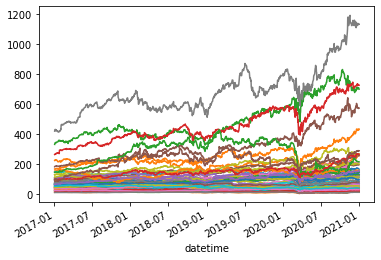

In [22]:
df.index = df['datetime']

for company in df.Ticker.unique():
    df[df.Ticker == company]['Adj Close'].plot()

In [23]:
df

,Average_Tone_min,Volume,Volume_Intensity_std,Average_Tone_std,Adj Close,Article_Count_std,Article_Count_sum,datetime,Volume_Intensity_mean,Volume_Intensity_sum,...,Close,Low,Volume_Intensity_min,Volume_Intensity_max,Ticker,High,Average_Tone_mean,Article_Count_mean,Average_Tone_max,Open
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-03,-2.299700,2390700.0,0.004924,1.782499,101.083084,37.403060,369.000000,2017-01-03,0.004870,0.048700,...,115.080002,114.639999,0.0000,0.014600,UPS,116.070000,0.714350,36.900000,4.173200,115.519997
2017-01-04,-2.602800,1830800.0,0.005691,1.460793,101.109444,46.833630,475.000000,2017-01-04,0.005770,0.057700,...,115.110001,114.959999,0.0000,0.015800,UPS,115.849998,0.331690,47.500000,2.446700,115.300003
2017-01-05,-2.691600,1856200.0,0.009780,1.725429,101.162132,81.234640,768.000000,2017-01-05,0.009250,0.092500,...,115.169998,114.849998,0.0000,0.028200,UPS,115.980003,0.295590,76.800000,2.976700,115.000000
2017-01-06,-0.542800,1767000.0,0.006568,1.158772,101.364174,50.353859,448.000000,2017-01-06,0.005840,0.058400,...,115.400002,114.519997,0.0000,0.018900,UPS,115.660004,0.672290,44.800000,3.402500,115.000000
2017-01-09,-1.417333,1965200.0,0.004975,1.637838,100.810791,31.318377,265.666667,2017-01-09,0.004197,0.041967,...,114.769997,114.500000,0.0000,0.015833,UPS,115.190002,0.849880,26.566667,3.585033,115.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,-1.622300,7550100.0,0.585469,1.010575,42.009998,2320.417102,11147.000000,2020-12-23,0.312500,2.812500,...,42.869999,42.619999,0.0000,1.719000,MO,43.070000,-0.114989,1238.555556,1.467800,42.680000
2020-12-24,-1.849400,6055800.0,0.563283,1.000696,41.720001,1859.522146,9253.000000,2020-12-24,0.311422,2.802800,...,41.720001,41.150002,0.0000,1.600600,MO,41.919998,0.057567,1028.111111,1.375500,41.889999
2020-12-28,-2.132200,8657900.0,0.664426,1.279141,41.480000,2255.830778,10899.000000,2020-12-28,0.356689,3.210200,...,41.480000,41.240002,0.0003,1.924200,MO,42.290001,-0.057344,1211.000000,1.292400,41.889999


In [24]:
df.to_csv(f'../data/companies_{len(df.Ticker.unique())}.csv')